In [368]:
import os
import sys
import re
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import copy
import pickle

In [369]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [370]:
sys.path.append('../../statmechlib')
from statmechlib.read_write import read_vasp
from statmechlib.preprocessing import Trajectory

In [371]:
target_raw = '../data/target_raw'
target_proc = '../data/target_processed'
working = '../data/working'

datasets = ['bcc_npt_langevin_300K',
            'fcc_npt_langevin_300K',
            'vac_npt_langevin_2000K',
            'i110_npt_langevin_2000K',
            'i111_npt_langevin_2000K',
            'screw_111_npt_langevin_2000K',
            'bcc_npt_langevin_3700K',
            'liq_3700K',
            'liq_5000K']

datasets_0k = ['bcc_0k',
               'fcc_0k',
               'vac_0k',
               'i110_0k',
               'i111_0k',
               'screw_111_0k']

In [372]:
#with open(os.path.join(target_proc,  "datasets.pickle"), 'wb') as fo:
#    pickle.dump(datasets, fo)
#
#print(datasets)

In [373]:
trajdirs = [target_raw + '/' + dataset for dataset in datasets]
trajdirs_0k = [target_raw + '/' + dataset for dataset in datasets_0k]

In [374]:
trajectories = {}
for name, traj_path in zip(datasets, trajdirs):
    trajectories[name] = read_vasp(traj_path)

Reading ../data/target_raw/bcc_npt_langevin_300K/OUTCAR
Reading ../data/target_raw/bcc_npt_langevin_300K/POSCAR
Reading ../data/target_raw/bcc_npt_langevin_300K/CONTCAR
Reading ../data/target_raw/bcc_npt_langevin_300K/XDATCAR
Reading ../data/target_raw/bcc_npt_langevin_300K/OSZICAR
Reading ../data/target_raw/bcc_npt_langevin_300K/INCAR
Reading ../data/target_raw/fcc_npt_langevin_300K/OUTCAR
Reading ../data/target_raw/fcc_npt_langevin_300K/POSCAR
Reading ../data/target_raw/fcc_npt_langevin_300K/CONTCAR
Reading ../data/target_raw/fcc_npt_langevin_300K/XDATCAR
Reading ../data/target_raw/fcc_npt_langevin_300K/OSZICAR
Reading ../data/target_raw/fcc_npt_langevin_300K/INCAR
Reading ../data/target_raw/vac_npt_langevin_2000K/OUTCAR
Reading ../data/target_raw/vac_npt_langevin_2000K/POSCAR
Reading ../data/target_raw/vac_npt_langevin_2000K/CONTCAR
Reading ../data/target_raw/vac_npt_langevin_2000K/XDATCAR
Reading ../data/target_raw/vac_npt_langevin_2000K/OSZICAR
Reading ../data/target_raw/vac_npt_l

In [375]:
trajectories_0k = {}
for name, traj_path in zip(datasets_0k, trajdirs_0k):
    trajectories_0k[name] = read_vasp(traj_path)

Reading ../data/target_raw/bcc_0k/OUTCAR
Reading ../data/target_raw/bcc_0k/POSCAR
Reading ../data/target_raw/bcc_0k/CONTCAR
Reading ../data/target_raw/bcc_0k/XDATCAR
Reading ../data/target_raw/bcc_0k/OSZICAR
Reading ../data/target_raw/bcc_0k/INCAR
Reading ../data/target_raw/fcc_0k/OUTCAR
Reading ../data/target_raw/fcc_0k/POSCAR
Reading ../data/target_raw/fcc_0k/CONTCAR
Reading ../data/target_raw/fcc_0k/OSZICAR
Reading ../data/target_raw/fcc_0k/INCAR
Reading ../data/target_raw/vac_0k/OUTCAR
Reading ../data/target_raw/vac_0k/POSCAR
Reading ../data/target_raw/vac_0k/CONTCAR
Reading ../data/target_raw/vac_0k/XDATCAR
Reading ../data/target_raw/vac_0k/OSZICAR
Reading ../data/target_raw/vac_0k/INCAR
Reading ../data/target_raw/i110_0k/OUTCAR
Reading ../data/target_raw/i110_0k/POSCAR
Reading ../data/target_raw/i110_0k/CONTCAR
Reading ../data/target_raw/i110_0k/XDATCAR
Reading ../data/target_raw/i110_0k/OSZICAR
Reading ../data/target_raw/i110_0k/INCAR
Reading ../data/target_raw/i111_0k/OUTCAR
Re

In [376]:
# Convert MD trajectory dicts to objects
trjs = {}
for k, trj in trajectories.items():
    trjs[k] = Trajectory(trj, inplace=False)

In [377]:
# Convert MD trajectory 0K configs to objects
trjs_0k = {}
for k, trj in trajectories_0k.items():
    trjs_0k[k] = Trajectory(trj, inplace=False)[-1]

In [378]:
# join 0 K configurations into a pseudo-trajectory
traj0k = copy.deepcopy(trjs_0k['bcc_0k'])

for k, trj in trjs_0k.items():
    print(k)
    if 'bcc' not in k:
        traj0k.append(trj)
    print(len(traj0k['box']))

bcc_0k
1
fcc_0k
2
vac_0k
3
i110_0k
4
i111_0k
5
screw_111_0k
6


In [379]:
traj0k['energy']

[-1656.3257, -1343.3027, -1640.2161, -1657.5219, -1657.8717, -1735.6202]

In [380]:
# Create an artificial configuration with large box and 0 energy
traj_inf = copy.deepcopy(trjs_0k['bcc_0k'])

In [838]:
# W parameters
l = 0.274
r_wse = 3.168
r_wse = 1.584
eta = 5.69
dE = 8.9

# equation of state. x is lattice expansion/compression parameter
def eos(x):
    a = (x - 1.0)*r_wse/l
    ene = np.exp(-a)
    ene *= -1.0 - a - 0.05*a**3
    return dE*ene

In [843]:
eos(0.9)*128

-837.1711089986524

In [844]:
def scale_configuration(trj, scale):
    """
    Scales box size by 10 to separate all atoms beyond cutoff, and sets energies and forces to 0.
    
    Parameters
    ----------
    trj: Trajectory object (or dict)
         Trajectory to be rescaled
    
    Returns
    -------
    trj: Trajectory object (or dict)
         Rescaled trajectory
    """
    trj['box'][0] = trj['box'][0]*scale
    trj['box0'] = trj['box0']*scale
    trj['energy'][0] = eos(scale)*len(trj['xyz'][0])
    trj['free_energy'][0] = eos(scale)*len(trj['xyz'][0])
    trj['total_energy'][0] = eos(scale)*len(trj['xyz'][0])
    trj['forces'][0] = np.zeros_like(trj['forces'][0])
    return trj

In [1000]:
n = (1.5-0.8)/0.05
print(n)
reos = np.linspace(0.8, 1.5, 15)*2.74

13.999999999999998


In [985]:
traj_eos = scale_configuration(copy.deepcopy(trjs_0k['bcc_0k']), 100.0)

In [986]:
for scale in np.linspace(0.8, 1.5, 15):
    traj_scale = copy.deepcopy(trjs_0k['bcc_0k'])
    traj_eos.append(scale_configuration(traj_scale, scale))

In [987]:
traj_eos['box']

[array([[1274.4894,    0.    ,    0.    ],
        [   0.    , 1274.4894,    0.    ],
        [   0.    ,    0.    , 1274.4894]]),
 array([[10.1959152,  0.       ,  0.       ],
        [ 0.       , 10.1959152,  0.       ],
        [ 0.       ,  0.       , 10.1959152]]),
 array([[10.8331599,  0.       ,  0.       ],
        [ 0.       , 10.8331599,  0.       ],
        [ 0.       ,  0.       , 10.8331599]]),
 array([[11.4704046,  0.       ,  0.       ],
        [ 0.       , 11.4704046,  0.       ],
        [ 0.       ,  0.       , 11.4704046]]),
 array([[12.1076493,  0.       ,  0.       ],
        [ 0.       , 12.1076493,  0.       ],
        [ 0.       ,  0.       , 12.1076493]]),
 array([[12.744894,  0.      ,  0.      ],
        [ 0.      , 12.744894,  0.      ],
        [ 0.      ,  0.      , 12.744894]]),
 array([[13.3821387,  0.       ,  0.       ],
        [ 0.       , 13.3821387,  0.       ],
        [ 0.       ,  0.       , 13.3821387]]),
 array([[14.0193834,  0.       ,  0.  

In [988]:
traj_eos['temp'] = [100.0 for _ in range(len(traj_eos['temp']))]

In [989]:
trjs['eos'] = traj_eos

In [382]:
traj_inf = scale_configuration(traj_inf, 100.0)

In [383]:
traj_inf['box0']

array([[127.44894465,   0.        ,   0.        ],
       [  0.        , 127.44894465,   0.        ],
       [  0.        ,   0.        , 127.44894465]])

In [385]:
traj0k['temp'] = [100.0 for _ in range(len(traj0k['temp']))]

In [386]:
traj0k.append(traj_inf)

In [387]:
trjs['relax'] = traj0k

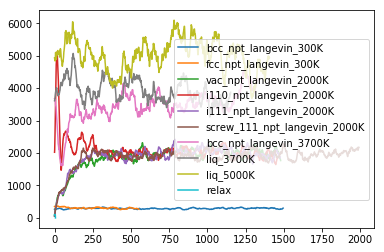

In [388]:
for key, trj in trjs.items():
    #print(i, list(zip(trj['atom_name'], trj['atom_num'])), len(trj['temp']))
    plt.plot(trj['temp'], label=key)

plt.legend()
plt.show()

In [389]:
def get_msd(xyzs):
    """Return mean squared displacement (msd) for a given trajectory (traj)."""
    msd = []
    for rs in xyzs:
        msd.append(np.mean((rs - xyzs[0])**2))
    #msd = [0.0 for _ in range(len(xyzs))]
    return np.array(msd)

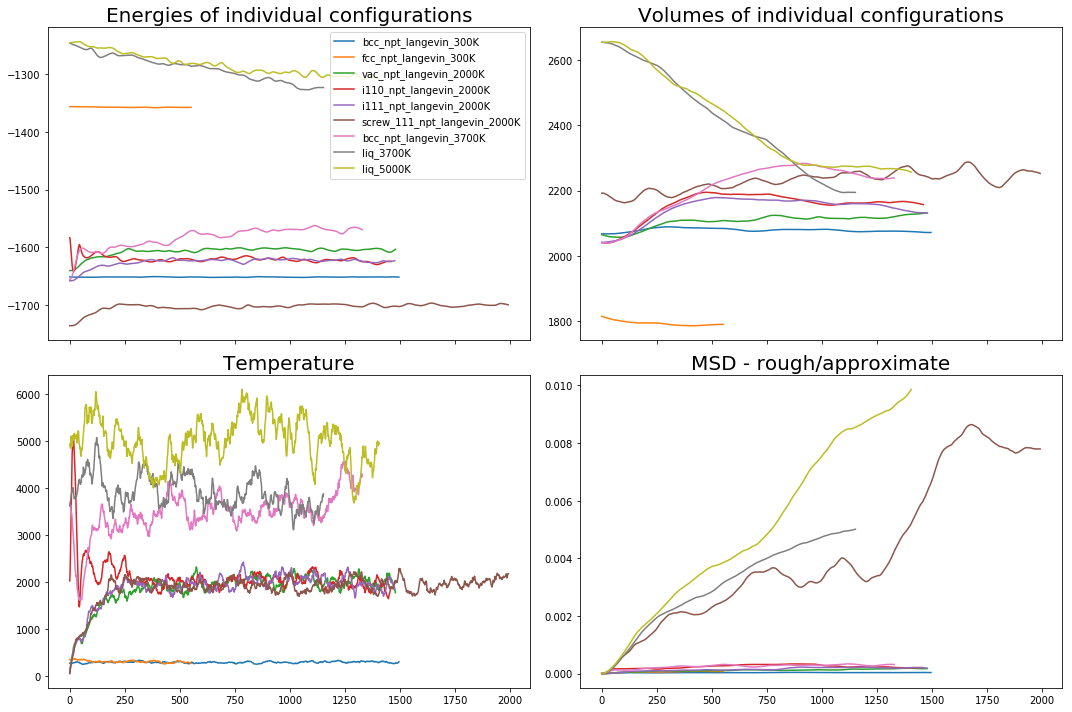

In [390]:
fig, axes = plt.subplots(2, 2, sharex='col', figsize=(15,10))

for key, traj in trjs.items():
    if 'relax' in key:
        continue

        
    #axes[0,0].plot([e/x.shape[0] for e, x in zip(traj['energy'], traj['xyz'])], label=dset)
    if 'screw' in key:
        axes[0,0].plot([e for e, x in zip(traj['energy'], traj['xyz'])], label=key)
        axes[0,1].plot([np.linalg.det(b) for b in traj['box']], label=key)
    else:
        axes[0,0].plot([e for e, x in zip(traj['energy'], traj['xyz'])], label=key)
        axes[0,1].plot([np.linalg.det(b) for b in traj['box']], label=key)


    axes[1,0].plot([t for t in traj['temp']], label=key)

    msd = get_msd(traj['xyz'])
    axes[1,1].plot(msd, label=key)

axes[0,0].legend()
axes[0,0].set_title('Energies of individual configurations', fontsize=20)
axes[0,1].set_title('Volumes of individual configurations', fontsize=20)       
axes[1,0].set_title('Temperature', fontsize=20)
axes[1,1].set_title('MSD - rough/approximate', fontsize=20)
fig.tight_layout()

In [391]:
[(k, len(v['energy'])) for k, v in trjs.items()]

[('bcc_npt_langevin_300K', 1496),
 ('fcc_npt_langevin_300K', 552),
 ('vac_npt_langevin_2000K', 1480),
 ('i110_npt_langevin_2000K', 1461),
 ('i111_npt_langevin_2000K', 1477),
 ('screw_111_npt_langevin_2000K', 1992),
 ('bcc_npt_langevin_3700K', 1329),
 ('liq_3700K', 1153),
 ('liq_5000K', 1406),
 ('relax', 7)]

In [392]:
cuts = {'bcc_npt_langevin_300K':500,
        'fcc_npt_langevin_300K':50,
        'vac_npt_langevin_2000K':300,
        'i110_npt_langevin_2000K':1000,
        'i111_npt_langevin_2000K':1000,
        'screw_111_npt_langevin_2000K':1400,
        'bcc_npt_langevin_3700K':600,
        'liq_3700K':800,
        'liq_5000K':800,
        'relax':0}

In [393]:
trj_samples = {}
for key, traj in trjs.items():
    if 'relax' not in key:
        trj_samples[key] = traj[cuts[key]::5]
    else:
        trj_samples[key] = traj[cuts[key]:]

In [990]:
trj_samples['eos'] = traj_eos

In [991]:
[(k, len(v['energy'])) for k, v in trj_samples.items()]

[('bcc_npt_langevin_300K', 200),
 ('fcc_npt_langevin_300K', 101),
 ('vac_npt_langevin_2000K', 236),
 ('i110_npt_langevin_2000K', 93),
 ('i111_npt_langevin_2000K', 96),
 ('screw_111_npt_langevin_2000K', 119),
 ('bcc_npt_langevin_3700K', 146),
 ('liq_3700K', 71),
 ('liq_5000K', 122),
 ('relax', 7),
 ('eos', 16)]

In [395]:
from statmechlib.preprocessing import pair_dist, force_targ, get_stats_EAM, get_stats_EAM_pairdist

In [397]:
# join 0 K configurations into a pseudo-trajectory
traj_md = copy.deepcopy(trj_samples['bcc_npt_langevin_300K'])

for k, trj in trj_samples.items():
    print(k)
    if 'relax' in k or 'bcc_npt' in k: 
        continue
        
    traj_md.append(trj)

    print(len(traj_md['box']))

bcc_npt_langevin_300K
fcc_npt_langevin_300K
301
vac_npt_langevin_2000K
537
i110_npt_langevin_2000K
630
i111_npt_langevin_2000K
726
screw_111_npt_langevin_2000K
845
bcc_npt_langevin_3700K
liq_3700K
916
liq_5000K
1038
relax


In [402]:
trj_fit = {'md':traj_md, 'relax':trj_samples['relax']}

In [427]:
trj_fit['md']['xyz'][-1].shape

(113, 3)

In [992]:
trj_fit['eos'] = traj_eos

In [993]:
trj_fit.keys()

dict_keys(['md', 'relax', 'eos'])

In [994]:
with open(os.path.join(working, "trj_fit.pickle"), 'wb') as fo:
    pickle.dump(trj_fit, fo)

In [995]:
weights = {k:1.0 for k in trj_fit}
weights['relax'] = 10.0
weights['eos'] = 2.0

target_data = {}

for key, trj in trj_fit.items():
    
    print('dataset #', key)

    # target data
    target_dict = {'type':'trajectory', 'weight':weights[key]}
    target_dict['box'] = trj['box']
    target_dict['xyz'] = trj['xyz']
    target_dict['energy'] = trj['energy']
    target_dict['forces'] = force_targ(trj['forces'])
    target_dict['temp'] = trj['temp']

    # save inverse temperature data (if T=0, set beta=1/300)
    target_dict['beta'] = np.empty_like(target_dict['temp'])
    for i, temp in enumerate(target_dict['temp']):
        if temp == 0.0:
            target_dict['beta'][i] = 1.0/300.0
        else:
            target_dict['beta'][i] = 1.0/temp

    target_dict['beta'] = list(target_dict['beta'])
            
    target_data[key] = target_dict

dataset # md
dataset # relax
dataset # eos


In [996]:
with open(os.path.join(working, "target_fit.pickle"), 'wb') as fo:
    pickle.dump(target_data, fo)

In [997]:
# load target data
with open(os.path.join(working, 'target_fit'+'.pickle'), 'rb') as fi:
    targ_dict = pickle.load(fi)

In [998]:
len(targ_dict['md']['energy']), len(targ_dict['eos']['energy'])

(1038, 16)

In [999]:
#sc = [2.74, 3.252, 3.804, 4.356, 4.908, 5.46]
#sc = [2.74, 3.25, 3.75, 4.5, 5.48]
sc = [2.5, 2.65, 2.75, 3.0, 3.25, 3.5, 3.75, 4.0, 4.25, 4.356, 4.5, 4.75, 5.0, 5.25, 5.5, 5.75]
#index = [0, 1, 3, 5, 8, 10]

#stats_data = {}

#stats_data['function'] = 'EAM-cubic-spline'
#stats_data['hyperparams'] = sc

for key, trj in trj_fit.items():
    
    print('dataset #', key)
    if 'eos' not in key:
        continue

    # statistics data
    stats_dict = {'energy':[], 'forces':[]}
    for ii, (xyz, box) in enumerate(zip(trj['xyz'], trj['box'])):
        print('conf', ii)
        
        a1, ar, a2, f1, fr, f2 = get_stats_EAM_pairdist(xyz, box, sc=sc)

        #print(xyz.shape, box)
        #print('x', a1.shape, rr.shape, np.sum(np.abs(a1)))
        #print('x', a1.shape, ar, a1, a2)
        
        stats_dict['energy'].append(np.array([ar, a2, a1]))
        stats_dict['forces'].append(np.array([fr, f2, f1]))

        #stats_dict['forces'].append(np.array([fr, f2, f1]))
               # add dataset
            
        #print('conf:', len(traj['xyz']), box.max())
        # plot pair distances - 
        #if ii == 10:
        #    plt.hist(rr.flatten(),100, alpha=1.0,label=key, histtype='step')
        #    plt.xlim(2,6)
        #    plt.ylim(0,1500)
            
    #plt.legend()
    stats_data[key] = stats_dict

dataset # md
dataset # relax
dataset # eos
conf 0
conf 1
Replicating: 2 2 2
conf 2
Replicating: 2 2 2
conf 3
Replicating: 2 2 2
conf 4
conf 5
conf 6
conf 7
conf 8
conf 9
conf 10
conf 11
conf 12
conf 13
conf 14
conf 15


In [1001]:
[(i, x[2,5]) for i, x in enumerate(stats_data['eos']['energy'])]

[(0, 0.0),
 (1, 2871.704949746209),
 (2, 1957.0612995615413),
 (3, 1270.0354794894415),
 (4, 775.8603672848167),
 (5, 439.76884070258643),
 (6, 226.9937774976612),
 (7, 102.76814281684393),
 (8, 35.72189713659567),
 (9, 6.889121080228055),
 (10, 0.13433706010541785),
 (11, 0.0),
 (12, 0.0),
 (13, 0.0),
 (14, 0.0),
 (15, 0.0)]

In [438]:
#sc = [2.74, 3.252, 3.804, 4.356, 4.908, 5.46]
#sc = [2.74, 3.25, 3.75, 4.5, 5.48]
sc = [2.5, 2.65, 2.75, 3.0, 3.25, 3.5, 3.75, 4.0, 4.25, 4.356, 4.5, 4.75, 5.0, 5.25, 5.5, 5.75]
#index = [0, 1, 3, 5, 8, 10]

stats_data = {}

stats_data['function'] = 'EAM-cubic-spline'
stats_data['hyperparams'] = sc

for key, trj in trj_fit.items():
    
    print('dataset #', key)
#    if 'relax' not in key:
#        continue

    # statistics data
    stats_dict = {'energy':[], 'forces':[]}
    for ii, (xyz, box) in enumerate(zip(trj['xyz'], trj['box'])):
        print('conf', ii)
        
        a1, ar, a2, f1, fr, f2 = get_stats_EAM_pairdist(xyz, box, sc=sc)

        #print(xyz.shape, box)
        #print('x', a1.shape, rr.shape, np.sum(np.abs(a1)))
        #print('x', a1.shape, ar, a1, a2)
        
        stats_dict['energy'].append(np.array([ar, a2, a1]))
        stats_dict['forces'].append(np.array([fr, f2, f1]))

        #stats_dict['forces'].append(np.array([fr, f2, f1]))
               # add dataset
            
        #print('conf:', len(traj['xyz']), box.max())
        # plot pair distances - 
        #if ii == 10:
        #    plt.hist(rr.flatten(),100, alpha=1.0,label=key, histtype='step')
        #    plt.xlim(2,6)
        #    plt.ylim(0,1500)
            
    #plt.legend()
    stats_data[key] = stats_dict

dataset # md
conf 0
conf 1
conf 2
conf 3
conf 4
conf 5
conf 6
conf 7
conf 8
conf 9
conf 10
conf 11
conf 12
conf 13
conf 14
conf 15
conf 16
conf 17
conf 18
conf 19
conf 20
conf 21
conf 22
conf 23
conf 24
conf 25
conf 26
conf 27
conf 28
conf 29
conf 30
conf 31
conf 32
conf 33
conf 34
conf 35
conf 36
conf 37
conf 38
conf 39
conf 40
conf 41
conf 42
conf 43
conf 44
conf 45
conf 46
conf 47
conf 48
conf 49
conf 50
conf 51
conf 52
conf 53
conf 54
conf 55
conf 56
conf 57
conf 58
conf 59
conf 60
conf 61
conf 62
conf 63
conf 64
conf 65
conf 66
conf 67
conf 68
conf 69
conf 70
conf 71
conf 72
conf 73
conf 74
conf 75
conf 76
conf 77
conf 78
conf 79
conf 80
conf 81
conf 82
conf 83
conf 84
conf 85
conf 86
conf 87
conf 88
conf 89
conf 90
conf 91
conf 92
conf 93
conf 94
conf 95
conf 96
conf 97
conf 98
conf 99
conf 100
conf 101
conf 102
conf 103
conf 104
conf 105
conf 106
conf 107
conf 108
conf 109
conf 110
conf 111
conf 112
conf 113
conf 114
conf 115
conf 116
conf 117
conf 118
conf 119
conf 120
conf 121

conf 789
Replicating: 1 5 1
conf 790
Replicating: 1 5 1
conf 791
Replicating: 1 5 1
conf 792
Replicating: 1 5 1
conf 793
Replicating: 1 5 1
conf 794
Replicating: 1 5 1
conf 795
Replicating: 1 5 1
conf 796
Replicating: 1 5 1
conf 797
Replicating: 1 5 1
conf 798
Replicating: 1 5 1
conf 799
Replicating: 1 5 1
conf 800
Replicating: 1 5 1
conf 801
Replicating: 1 5 1
conf 802
Replicating: 1 5 1
conf 803
Replicating: 1 5 1
conf 804
Replicating: 1 5 1
conf 805
Replicating: 1 5 1
conf 806
Replicating: 1 5 1
conf 807
Replicating: 1 5 1
conf 808
Replicating: 1 5 1
conf 809
Replicating: 1 5 1
conf 810
Replicating: 1 5 1
conf 811
Replicating: 1 5 1
conf 812
Replicating: 1 5 1
conf 813
Replicating: 1 5 1
conf 814
Replicating: 1 5 1
conf 815
Replicating: 1 5 1
conf 816
Replicating: 1 5 1
conf 817
Replicating: 1 5 1
conf 818
Replicating: 1 5 1
conf 819
Replicating: 1 5 1
conf 820
Replicating: 1 5 1
conf 821
Replicating: 1 5 1
conf 822
Replicating: 1 5 1
conf 823
Replicating: 1 5 1
conf 824
Replicating

In [1002]:
with open(os.path.join(working, "stats_fit.pickle"), 'wb') as fo:
    pickle.dump(stats_data, fo)

In [1003]:
#%%writefile -a ../src/optimize/optscript.py

from statmechlib.forcefields import sd2_loss, utot_EAM, ftot_EAM, udif_print
from scipy.optimize import fmin

In [1004]:
#%%writefile -a ../src/optimize/optscript.py

# load stats data
with open(os.path.join(working, 'stats_fit'+'.pickle'), 'rb') as fi:
    stats_dict = pickle.load(fi)

In [1005]:
#%%writefile -a ../src/optimize/optscript.py

# load stats data
with open(os.path.join(working, 'pars_in'+'.pickle'), 'rb') as fi:
    pars_dict = pickle.load(fi)

In [1006]:
#%%writefile -a ../src/optimize/optscript.py
#pars_in = [pars_dict['embed'][0], pars_dict['embed'][2], *pars_dict['pair']]
pars_in = pars_dict['embed'] + pars_dict['pair']
print(pars_in)

[-0.344540412587315, 1.6869558429105695e-05, 7.262799609949834, 2.8551814788414784, -1.1750824011719558, 0.5925315310384949, -0.41006381316375573, 0.11872947102754242]


In [1007]:
# Final scaling and normalization of data
# %load ../src/optimize/optscript.py

# scale energies (subtract energy of an isolated atom)
# determine interaction energy
print(targ_dict['relax']['energy'][0], len(targ_dict['relax']['xyz'][0]))
u_t = targ_dict['relax']['energy'][0]/len(targ_dict['relax']['xyz'][0])
u_e = -8.9 # external energy from atom (experimental)
u_i = u_t - u_e # internal energy per atom (to be subtracted from all atoms)
print(u_t, u_e, u_i)

emin = 0.0
esum = 0.0
isum = 0.0
lemin = 0.0
lesum = 0.0
lisum = 0.0
for key, trj in targ_dict.items():
    if 'eos' in key:
        continue
    for i in range(len(targ_dict[key]['energy'])):
        targ_dict[key]['energy'][i] -= u_i*targ_dict[key]['xyz'][i].shape[0]
        enex = targ_dict[key]['energy'][i]/targ_dict[key]['xyz'][i].shape[0]

#        if 'fcc' in key:
#            esum += enex
#            isum += 1.0
#            if enex < emin:
#                imin = i
#                #print(enex)
#                emin = enex
#                xmin = targ_dict[key]['xyz'][i]
#                bmin = targ_dict[key]['box'][i]
#                smin = stats_dict[key]['energy'][i]

#        if 'liq_5000K' in key:
#            lesum += enex
#            lisum += 1.0
#            if enex < lemin:
#                limin = i
#                #print(enex)
#                lemin = enex
#                lxmin = targ_dict[key]['xyz'][i]
#                lbmin = targ_dict[key]['box'][i]
#                lsmin = stats_dict[key]['energy'][i]
#                lnat = targ_dict[key]['xyz'][i].shape[0]

#print('Emin', emin, esum/isum)

# temporary fix - set fcc energy at 0K to minimum energy of 300K trajectory
#targ_dict['relax']['energy'][1] = emin*targ_dict['relax']['xyz'][1].shape[0]
#targ_dict['relax']['xyz'][1] = xmin
#targ_dict['relax']['box'][1] = bmin
#stats_dict['relax']['energy'][1] = smin

#targ_dict['relax']['energy'][5] = lemin*lnat
#targ_dict['relax']['xyz'][5] = lxmin
#targ_dict['relax']['box'][5] = lbmin
#stats_dict['relax']['energy'][5] = lsmin

targ_dict['relax']['energy'][-1] = 0.0

#targ_dict['relax']['energy'][5] = targ_dict['relax']['energy'][6]
#targ_dict['relax']['xyz'][5] = targ_dict['relax']['xyz'][6]
#targ_dict['relax']['box'][5] = targ_dict['relax']['box'][6]
#stats_dict['relax']['energy'][5] = stats_dict['relax']['energy'][6]

print('OK energies:', targ_dict['relax']['energy'])

-1656.3257 128
-12.94004453125 -8.9 -4.04004453125
OK energies: [-1139.2, -906.9778906249999, -1127.13044453125, -1136.3561554687499, -1136.7059554687498, -1190.21418828125, 0.0]


In [1008]:
print('OK energies:', targ_dict['eos']['energy'])

OK energies: [-2.9688679595213743e-239, 845.2656372627717, -271.80472210709036, -837.1711089986524, -1079.5267350307167, -1139.2, -1100.8887858645915, -1014.6561261471662, -909.2807161131147, -800.6633444635341, -697.0611202328876, -602.3043063713139, -517.742999456512, -443.4032853774631, -378.657941519064, -322.6037245559544]


In [1009]:
#Add Inf configurations at the end of the MD trajectory
for key in targ_dict['md']:
    if 'type' in key or 'weight' in key:
        continue
    #print(key, type(targ_dict['md'][key][-1]))
    for i in range(100):
        targ_dict['md'][key].append(targ_dict['relax'][key][-1])

In [1010]:
stats_dict['md'].keys()
for key in stats_dict['md']:
    #print(key, type(stats_dict['md'][key]))
    for i in range(100):
        stats_dict['md'][key].append(stats_dict['relax'][key][-1])

In [1011]:
for key in targ_dict['md']:
    if 'type' in key or 'weight' in key:
        continue
    #print(key, len(stats_dict['md'][key]), type(stats_dict['md'][key]))
    print(key, len(targ_dict['md'][key]), type(targ_dict['md'][key]))

box 1138 <class 'list'>
xyz 1138 <class 'list'>
energy 1138 <class 'list'>
forces 1138 <class 'list'>
temp 1138 <class 'list'>
beta 1138 <class 'list'>


In [1043]:
targ_dict['eos']['weight'] = 1.0

In [1044]:
#targ_dict['relax']['weight'] = 5.0
print([targ_dict[k]['weight'] for k in targ_dict])

[1.0, 10.0, 1.0]


In [1045]:
print([2.74, 3.252, 3.804, 4.356, 4.908, 5.46])
print(stats_dict['hyperparams'])

[2.74, 3.252, 3.804, 4.356, 4.908, 5.46]
[2.5, 2.65, 2.75, 3.0, 3.25, 3.5, 3.75, 4.0, 4.25, 4.356, 4.5, 4.75, 5.0, 5.25, 5.5, 5.75]


In [1014]:
index = [2, 4, 6, 9, 12, 14]
index = np.array([True if i in index else False for i in range(len(stats_dict['hyperparams']))])
print(np.array(stats_dict['hyperparams'])[index])

[2.75  3.25  3.75  4.356 5.    5.5  ]


In [1015]:
def select_nodes(stats_input, index):
    """
    Select only configuration statistics from stats (spline nodes) that are given in index.
    """
    
    stats_select = copy.deepcopy(stats_input)
    
    for key, stats in stats_select.items():
        if type(stats) == dict and 'energy' in stats.keys():
            for i, conf in enumerate(stats['energy']):
                new_conf = np.empty((3, sum(index)), dtype=float)
                new_conf[0] = conf[0][index]
                new_conf[1] = conf[1][index]
                new_conf[2] = conf[2][index]
                stats['energy'][i] = new_conf
                
    stats_select['hyperparams'] = list(np.array(stats_select['hyperparams'])[index])

    return stats_select

In [1016]:
stats_opt = select_nodes(stats_dict, index)
#stats_opt = copy.deepcopy(stats_dict)

In [1017]:
#stats_opt['function'] = 'EAM-cubic-spline'
#stats_opt['hyperparams'] = sc

In [1018]:
stats_opt['hyperparams']

[2.75, 3.25, 3.75, 4.356, 5.0, 5.5]

In [1046]:
# prepare data for fitting
stats = []
target = []
for key in list(targ_dict.keys()):
    stats.append(stats_opt[key])
    target.append(targ_dict[key])

In [1047]:
pars_dict['pair']

[7.262799609949834,
 2.8551814788414784,
 -1.1750824011719558,
 0.5925315310384949,
 -0.41006381316375573,
 0.11872947102754242]

In [746]:
multi_pars = [pars_in]

In [747]:
multi_pars

[[-0.344540412587315,
  1.6869558429105695e-05,
  7.262799609949834,
  2.8551814788414784,
  -1.1750824011719558,
  0.5925315310384949,
  -0.41006381316375573,
  0.11872947102754242]]

In [939]:
pars = multi_pars[0]
#optimal_parameters = []
print(pars)
sd_ini = sd2_loss(pars, stats, target, utot_EAM)
print('Initial sd2:', sd_ini)
output = fmin(sd2_loss, pars, args=(stats, target, utot_EAM), maxiter=100000, maxfun=100000, disp=0, full_output=1,ftol=1e-6)
params_uopt = output[0]
print('Opt #', 0, output[1:])
print("Optimized parameters:")
print(*params_uopt)
#optimal_parameters.append(tuple([output[1:], params_uopt]))

[-3.74132698e+00 -3.84519381e-04  8.77628167e+00 -2.20871168e+00
  3.35359442e+00 -9.38564806e-01 -5.63659772e-01  9.27857151e-01]
Initial sd2: 18.385948858900285
Opt # 0 (18.385947572509735, 1231, 1848, 0)
Optimized parameters:
-4.106337580417493 -0.00043474528399824625 11.900001139980201 -2.1909805889672187 3.298635451314461 -0.8620135176999827 -0.6197461173620957 1.0165861995570689


In [810]:
params_uopt

array([-3.74366839e+00, -3.82503855e-04,  9.95130195e+00, -2.40887446e+00,
        3.04037104e+00, -4.33470879e-01, -9.53991736e-01,  1.05194950e+00])

In [750]:
multi_pars =[pars_in]

In [751]:
multi_pars.append(list(optimal_parameters[0][1]))

In [752]:
multi_pars

[[-0.344540412587315,
  1.6869558429105695e-05,
  7.262799609949834,
  2.8551814788414784,
  -1.1750824011719558,
  0.5925315310384949,
  -0.41006381316375573,
  0.11872947102754242],
 [-0.35206612437975615,
  9.133245928096229e-05,
  -9.104710583927625,
  -2.330660092181559,
  3.7660858018253074,
  -1.8353825384526679,
  0.0524308338710909,
  0.0854579607184422]]

In [1111]:
# Formatting for optimization
multi_pars = []

#pars_in1 = multi_pars[0]
#pars_in2 = multi_pars[1]

pars_in1 = optimal_parameters[0][1]
pars_in2 = optimal_parameters[2][1]
pars_in3 = optimal_parameters[19][1]


#pars_in1 = [-2.21684325e+00, -1.77860942e-04, -3.66546338e+00, -1.71191389e+00, 4.38944526e+00, -2.66122494e+00,  7.24452435e-01,  2.29732818e-01]
#pars_in2 = [-1.27104003e+00, -4.74103470e-05, -1.81120680e+01, -1.95915397e+00, 4.09985823e+00, -1.83714241e+00, -1.61099628e-02,  2.92927073e-01]

print(pars_in1)
print(pars_in2)
print(pars_in3)

multi_pars.append(pars_in1)
multi_pars.append(pars_in2)
multi_pars.append(pars_in3)

for _ in range(5):
    pars = np.array(pars_in1)
    pars += np.random.standard_normal(pars.shape)*0.05
    print(pars)
    multi_pars.append(pars)

for _ in range(5):
    pars = np.array(pars_in2)
    pars += np.random.standard_normal(pars.shape)*0.05
    multi_pars.append(pars)

for _ in range(5):
    pars = np.array(pars_in3)
    pars += np.random.standard_normal(pars.shape)*0.05
    multi_pars.append(pars)
    
for _ in range(5):
    pars = 0.5*(np.array(pars_in1) + np.array(pars_in2))
    pars += np.random.standard_normal(pars.shape)*0.05
    multi_pars.append(pars)

for _ in range(5):
    pars = 0.5*(np.array(pars_in1) + np.array(pars_in3))
    pars += np.random.standard_normal(pars.shape)*0.05
    multi_pars.append(pars)

for _ in range(5):
    pars = 0.5*(np.array(pars_in2) + np.array(pars_in3))
    pars += np.random.standard_normal(pars.shape)*0.05
    multi_pars.append(pars)

[-1.81439037e+00 -3.17089234e-05  1.95868228e+01 -3.22042901e+00
  3.25464368e+00 -1.82335287e+00  5.61372813e-01  1.54544574e-02]
[-1.73295527e+00 -3.16303322e-05  1.95089337e+01 -3.17344541e+00
  3.32792808e+00 -1.86782509e+00  6.12184505e-01 -1.29391041e-02]
[-1.83276933e+00 -1.56985762e-04  2.46025632e+01 -3.45190039e+00
  3.92745535e+00 -2.05262905e+00  6.83468644e-01 -1.31030138e-02]
[-1.91314853e+00  1.70084100e-02  1.96559775e+01 -3.18544836e+00
  3.27728875e+00 -1.78562891e+00  5.42308329e-01  6.91278042e-02]
[-1.81585666  0.03575062 19.60737134 -3.25038727  3.18823969 -1.81327572
  0.46873771  0.05731779]
[-1.69846863e+00  9.02129229e-03  1.96444735e+01 -3.15350391e+00
  3.26331617e+00 -1.78373385e+00  4.96361380e-01 -1.01021206e-02]
[-1.88559347  0.03945928 19.58683917 -3.16752303  3.32369245 -1.78458409
  0.51230348 -0.03612837]
[-1.87979894 -0.03974565 19.5526934  -3.23196152  3.20842073 -1.82400999
  0.5443434  -0.04735438]


In [1112]:
optimal_parameters = []
for i, pars in enumerate(multi_pars):
    sd_ini = sd2_loss(list(pars), stats, target, utot_EAM, None, [4])
    print('Initial sd2:', sd_ini)
    output = fmin(sd2_loss, list(pars), args=(stats, target, utot_EAM, None, [4]), maxiter=100000, maxfun=100000, disp=0, full_output=1,ftol=1e-6)
    params_uopt = output[0]
    print('Opt #', i, output[1:])
    print("Optimized parameters:")
    print(*params_uopt)
    optimal_parameters.append(tuple([output[1:], params_uopt]))

Initial sd2: 0.0012806525040711763
Opt # 0 (0.0012429390640712535, 1498, 2213, 0)
Optimized parameters:
-1.7219604741256633 -8.474221356420038e-06 18.62340669464194 -3.2276686732080844 3.298150194088217 -1.8805264637755557 0.6167355063865583 -0.01581567175371158
Initial sd2: 0.0012640735756840262
Opt # 1 (0.0012432569658527711, 818, 1237, 0)
Optimized parameters:
-1.731568002643117 -9.295221600920463e-06 18.66581542185889 -3.2315052470803884 3.2906846892269095 -1.8747407190433212 0.610640461057655 -0.012449428388203967
Initial sd2: 0.0035162565170429485
Opt # 2 (0.0012429390643486464, 1756, 2571, 0)
Optimized parameters:
-1.7219689671747918 -8.472981103908181e-06 18.623348517121293 -3.2276778402257635 3.2981465591918853 -1.8805276870050665 0.6167325600852172 -0.015813202213313053
Initial sd2: 16.892089041831632
Opt # 3 (0.0032462975845496678, 1595, 2381, 0)
Optimized parameters:
-2.2096929957083953 -5.269820272234572e-05 21.203605213756397 -3.993531705614541 3.4341548305708125 -1.91467

../../statmechlib/statmechlib/forcefields/eam.py:226: RuntimeWarning: overflow encountered in exp
  #print('ustat', utot_func(params, u_stat))


Opt # 4 (0.004213887507517474, 1043, 1610, 0)
Optimized parameters:
-2.159104717527848 -2.783396976655093e-06 18.00421909246589 -3.5070592107080496 3.1689279258172514 -1.96663054757075 0.5719774974207513 0.06543524473435364
Initial sd2: 16.65741163084716
Opt # 5 (0.0012508968476529925, 1568, 2360, 0)
Optimized parameters:
-1.6978524559818453 -6.573569744858505e-06 18.618170911454236 -3.2037742133205396 3.2810083107106234 -1.8664768195952788 0.6174863924518461 -0.020449061504894485
Initial sd2: 18.079506221923854
Opt # 6 (0.007548170529998349, 1294, 1967, 0)
Optimized parameters:
-1.5574694637883866 0.00011896639161568 17.356007523387618 -4.629353141826617 3.444407850450543 -1.8977496665824853 0.6150196967223298 -0.04295716882385448
Initial sd2: 14.119191923795672
Opt # 7 (0.014121471142133647, 530, 851, 0)
Optimized parameters:
-1.4575437902535233 2.126540020575114e-05 23.524043305277544 -4.490621945929421 3.3101390144042946 -1.6005014489007228 0.5641279019092464 -0.059293881339764404


6
Targ: [-1139.2, -906.9778906249999, -1127.13044453125, -1136.3561554687499, -1136.7059554687498, -1190.21418828125]
Model: [-1137.3255277588587, -907.0760560915837, -1128.868505251373, -1134.0988229448733, -1133.7849469859684, -1193.7679853118614]
[0.046875   0.05555556 0.04724409 0.04651163 0.04651163 0.04444444]
0 0.0012429390640712535
1 0.0012432569658527711
2 0.0012429390643486464
5 0.0012508968476529925
11 0.003040460910012382
12 0.0030093733507633776
19 0.0014752429197976624
22 0.002941431863031888
29 0.002517948482748569


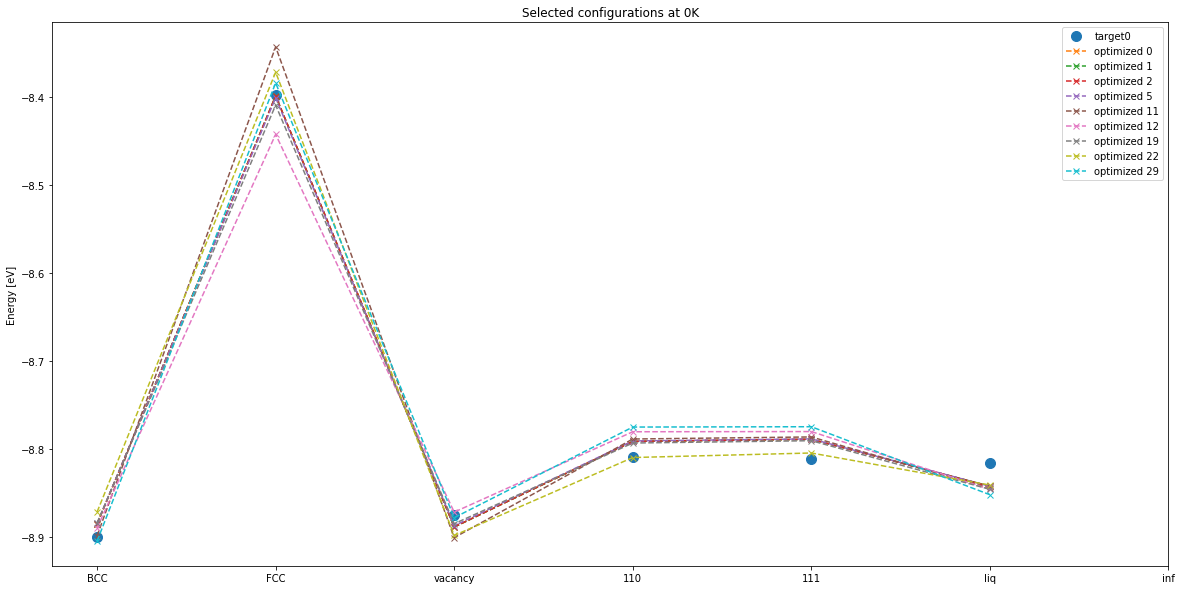

In [1121]:
plt.figure(figsize=(20,10))

nat = np.array([len(x) for x in targ_dict['relax']['xyz']])[:-1]
print(len(nat))

for i, params_uopt in enumerate(optimal_parameters):

    #print(params_uopt[1])

    opti_out, targ_out = udif_print(params_uopt[1], stats, target, utot_EAM, [4])
    plt.title('Selected configurations at 0K')
    if i == 0:
        print('Targ:', targ_out[-2][:-1])
        print('Model:', opti_out[-2][:-1])

        #nat = np.array([len(x) for x in targ_dict['relax']['xyz']])
        print(len(np.array(targ_out[-2][:-1]))/nat)
        plt.plot(np.array(targ_out[-2][:-1])/nat, 'o', label='target'+str(i), markersize=10)
        
    if params_uopt[0][0] > 3.1e-3:
        continue
    #if i != 10 and i != 12:
    #    continue
    print(i, params_uopt[0][0])

        
    #print('Opti:', [o for o in opti_out[-1][:-1]])
    plt.plot(np.array([o for o in opti_out[-2][:-1]])/nat, 'x--', label='optimized '+str(i))
#    else:
#        plt.plot([o for o in opti_out[-1][:-1]], 'x--', label='optimized '+str(i))
#        plt.plot(targ_out[-1][:-1], 'o', markersize=10)

plt.xticks([0, 1, 2, 3, 4, 5, 6], ['BCC','FCC', 'vacancy','110','111','liq','inf'])
plt.ylabel('Energy [eV]')
#plt.ylim(-1145, -1136)
#plt.ylim(-8.905, -8.7533)
#plt.ylim(-8.9, -8.35)
#plt.xlim(0, 4)

plt.legend()

15
Targ: [845.2656372627717, -271.80472210709036, -837.1711089986524, -1079.5267350307167, -1139.2, -1100.8887858645915, -1014.6561261471662, -909.2807161131147, -800.6633444635341, -697.0611202328876, -602.3043063713139, -517.742999456512, -443.4032853774631, -378.657941519064, -322.6037245559544]
Model: [844.3143667428608, -276.8466251694117, -841.7749820996432, -1083.2993885888839, -1137.3255277588587, -1101.7906428403505, -1017.0044113571723, -913.4288021924965, -805.8333868181388, -700.283008997542, -601.3487873812942, -514.0706982578726, -442.0351753035544, -381.92280091640913, -329.64906777481093]
[0.1171875 0.1171875 0.1171875 0.1171875 0.1171875 0.1171875 0.1171875
 0.1171875 0.1171875 0.1171875 0.1171875 0.1171875 0.1171875 0.1171875
 0.1171875]
0 0.0012429390640712535
1 0.0012432569658527711
2 0.0012429390643486464
5 0.0012508968476529925
11 0.003040460910012382
12 0.0030093733507633776
19 0.0014752429197976624
22 0.002941431863031888
29 0.002517948482748569


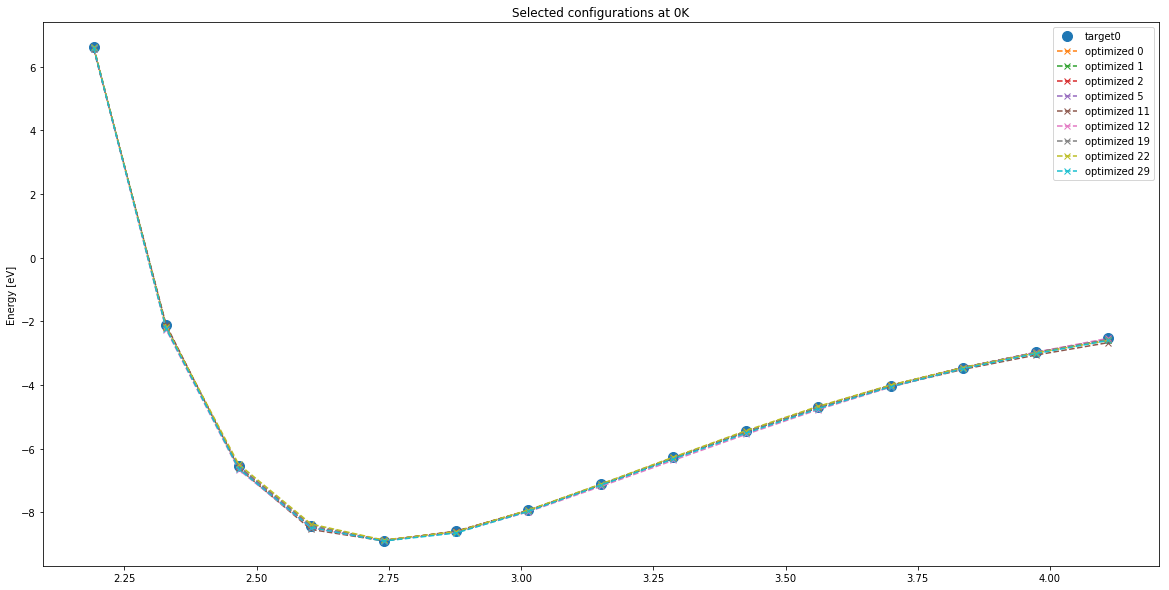

In [1120]:
plt.figure(figsize=(20,10))

nat = np.array([len(x) for x in targ_dict['eos']['xyz']])[1:]
print(len(nat))

for i, params_uopt in enumerate(optimal_parameters):

    #print(params_uopt[1])

    opti_out, targ_out = udif_print(params_uopt[1], stats, target, utot_EAM, [4])
    plt.title('Selected configurations at 0K')
    if i == 0:
        print('Targ:', targ_out[-1][1:])
        print('Model:', opti_out[-1][1:])

        #nat = np.array([len(x) for x in targ_dict['relax']['xyz']])
        print(len(np.array(targ_out[-1][1:]))/nat)
        plt.plot(reos, np.array(targ_out[-1][1:])/nat, 'o', label='target'+str(i), markersize=10)
        
    if params_uopt[0][0] > 0.31e-2:
        continue
    #if i != 10 and i != 12:
    #    continue
    print(i, params_uopt[0][0])

        
    #print('Opti:', [o for o in opti_out[-1][:-1]])
    plt.plot(reos, np.array([o for o in opti_out[-1][1:]])/nat, 'x--', label='optimized '+str(i))
#    else:
#        plt.plot([o for o in opti_out[-1][:-1]], 'x--', label='optimized '+str(i))
#        plt.plot(targ_out[-1][:-1], 'o', markersize=10)

#plt.xticks([0, 1, 2, 3, 4, 5, 6], ['BCC','FCC', 'vacancy','110','111','liq','inf'])
plt.ylabel('Energy [eV]')
#plt.ylim(-1145, -1136)
#plt.ylim(-8.905, -8.7533)
#plt.ylim(-8.9, -8.35)
#plt.xlim(0, 4)

plt.legend()

1138
[8.890625 8.890625 8.890625 ... 8.890625 8.890625 8.890625]
0 0.0012429390640712535
1 0.0012432569658527711
2 0.0012429390643486464
5 0.0012508968476529925
11 0.003040460910012382
12 0.0030093733507633776
19 0.0014752429197976624
22 0.002941431863031888
29 0.002517948482748569


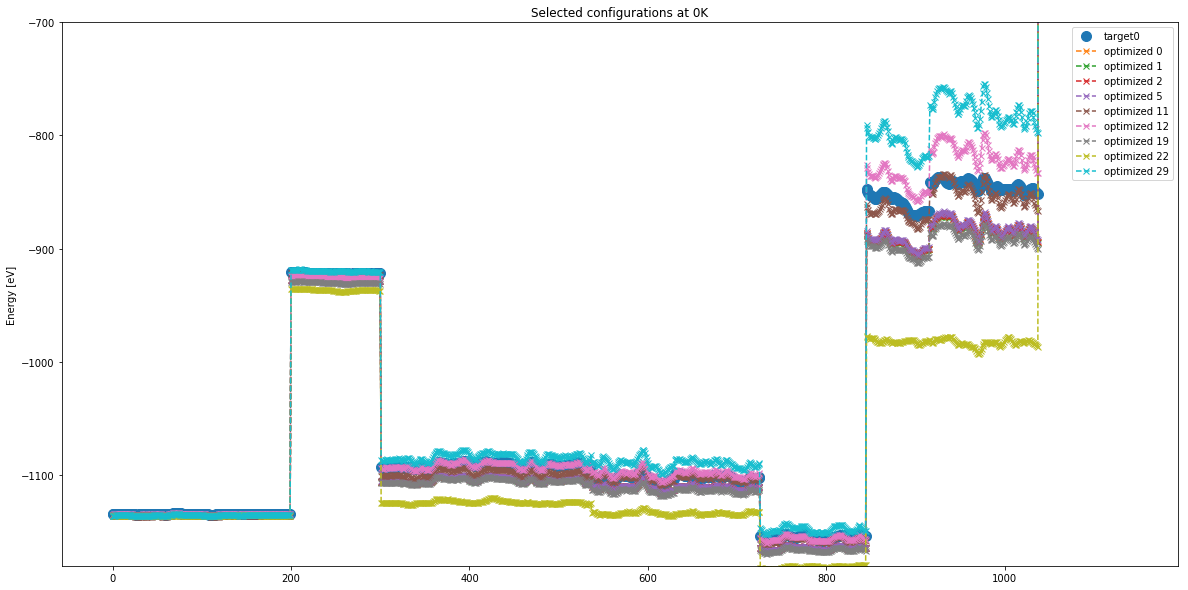

In [1119]:
plt.figure(figsize=(20,10))

nat = np.array([len(x) for x in targ_dict['md']['xyz']])[:]
print(len(nat))

for i, params_uopt in enumerate(optimal_parameters):

    #print(params_uopt[1])

    opti_out, targ_out = udif_print(params_uopt[1], stats, target, utot_EAM,[4])
    plt.title('Selected configurations at 0K')
    if i == 0:
        #print('Targ:', targ_out[0][:])
        #print('Model:', opti_out[0][:])

        #nat = np.array([len(x) for x in targ_dict['relax']['xyz']])
        print(len(np.array(targ_out[0][:]))/nat)
        #plt.plot(np.array(targ_out[0][:])/nat, 'o', label='target'+str(i), markersize=10)
        plt.plot(np.array(targ_out[0][:]), 'o', label='target'+str(i), markersize=10)

        
    if params_uopt[0][0] > 0.31e-2:
        continue
    #if i != 10 and i != 12:
    #    continue
    print(i, params_uopt[0][0])

    #print('Opti:', [o for o in opti_out[-1][:-1]])
    #plt.plot(np.array([o for o in opti_out[0][:]])/nat, 'x--', label='optimized '+str(i))
    plt.plot(np.array([o for o in opti_out[0][:]]), 'x--', label='optimized '+str(i))

#    else:
#        plt.plot([o for o in opti_out[-1][:-1]], 'x--', label='optimized '+str(i))
#        plt.plot(targ_out[-1][:-1], 'o', markersize=10)

#plt.xticks([0, 1, 2, 3, 4, 5, 6], ['BCC','FCC', 'vacancy','110','111','liq','inf'])
plt.ylabel('Energy [eV]')
#plt.ylim(-1145, -1136)
#plt.ylim(-8.905, -8.533)
#plt.ylim(-8.9, -8.35)

plt.ylim(-1180,-700)
#plt.ylim(-1136,-1132)

plt.legend()

In [1081]:
for i, params_uopt in enumerate(optimal_parameters):
    if params_uopt[0][0] > 3e-3:
        continue
    print(i, params_uopt[1])


0 [-6.40386694e-01  4.55421623e-05  1.47596411e+01 -3.28930776e+00
  3.00810593e+00 -1.45206836e+00  3.64510676e-01 -4.73073383e-02]
1 [-6.40384877e-01  4.55425528e-05  1.47595943e+01 -3.28931140e+00
  3.00810716e+00 -1.45207164e+00  3.64513813e-01 -4.73088297e-02]
2 [-6.40381840e-01  4.55427678e-05  1.47595365e+01 -3.28930867e+00
  3.00811403e+00 -1.45207906e+00  3.64520008e-01 -4.73114707e-02]
19 [-8.22483533e-01  8.94376574e-06  1.98340385e+01 -3.35142547e+00
  3.18038537e+00 -1.34334125e+00  1.74653347e-01  6.60838309e-02]


In [1084]:
pars_out = {}
pars_out['pair_nodes'] = stats_opt['hyperparams']
pars_out['mb_node'] = stats_opt['hyperparams'][-1:]

In [1085]:
pars_list = [optimal_parameters[1], optimal_parameters[19]

In [1087]:
pars_out['params'] = pars_list

In [1093]:
#pars_out
#optimal_list = [pars_out]

In [1094]:
with open(os.path.join(working, 'pars_out.pickle'), 'rb') as fi:
    optimal_list = pickle.load(fi)

if type(optimal_list) != list:
    optimal_list = [optimal_list]

optimal_list.append(pars_out)

with open(os.path.join(working, 'pars_out.pickle'), 'wb') as fo:
    pickle.dump(optimal_list, fo)

In [1095]:
with open(os.path.join(working, 'pars_out.pickle'), 'rb') as fi:
    optimal_list = pickle.load(fi)

In [1096]:
optimal_list

[{'pair_nodes': [2.75, 3.25, 3.75, 4.356, 5.0, 5.5],
  'mb_node': [5.5],
  'params': [array([-6.40384877e-01,  4.55425528e-05,  1.47595943e+01, -3.28931140e+00,
           3.00810716e+00, -1.45207164e+00,  3.64513813e-01, -4.73088297e-02]),
   array([-8.22483533e-01,  8.94376574e-06,  1.98340385e+01, -3.35142547e+00,
           3.18038537e+00, -1.34334125e+00,  1.74653347e-01,  6.60838309e-02])]}]

In [1059]:
# W parameters
l = 0.274
r_wse = 3.168
r_wse = 1.584
eta = 5.69
dE = 8.9

# equation of state. x is lattice expansion/compression parameter
def eos(x):
    a = (x - 1.0)*r_wse/l
    ene = np.exp(-a)
    ene *= -1.0 - a - 0.05*a**3
    return dE*ene

In [1060]:
f_spline = lambda r, aa, kk: sum([a*(rk - r)**3 for a, rk in zip(aa, kk) if r < rk and r > 0.01])

# electronic density function (cubic splines)
#rho = lambda r, a, k: sum([c*(p - r)**3 for c, p in zip(a, k) if r < p])

rho = f_spline

# embedding function
F = lambda d, a: a[0]*d**0.5 + a[1]*d + a[2]*d**2

# pair potential function (same spline form as electronic density)
V = rho

V = lambda r, aa, cc: sum([a*(rc - r)**3 for a, rc in zip(aa, cc) if r < rc])

# Embedding function. Parameters: electronic density (d), coefficients for 1/2, 1, and 2 powers of density
F = lambda d, a: a[0]*d**0.5 + a[1]*d + a[2]*d**2

# Cohesive potential (cubic splines - same form as V)
phi = V

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  8.,
         0.,  6.,  0.,  0.,  0.,  0.,  0., 12.,  0.,  0., 24.,  0.,  8.,
         0.,  0.,  3.,  0.,  0., 24., 12.,  0.,  0., 12.,  0.,  8.,  0.,
         0.,  3.,  0.,  0.,  6.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([ 0.        ,  0.22074804,  0.44149608,  0.66224412,  0.88299216,
         1.1037402 ,  1.32448824,  1.54523628,  1.76598432,  1.98673236,
         2.20748039,  2.42822843,  2.64897647,  2.86972451,  3.09047255,
         3.31122059,  3.53196863,  3.75271667,  3.97346471,  4.19421275,
         4.41496079,  4.63570883,  4.85645687,  5.07720491,  5.29795295,
         5.51870099,  5.73944903,  5.96019707,  6.1809451 ,  6.40169314,
         6.62244118,  6.84318922,  7.06393726,  7.2846853 ,  7.50543334,
         7.72618138,  7.94692942,  8.16767746,  8.3884255 ,  8.60917354,
         8.82992158,  9.05066962,  9.27141766,  9.4921657 ,  9.71291374,
         9.93366178, 10.15440981, 10.37515785, 10.59590589,

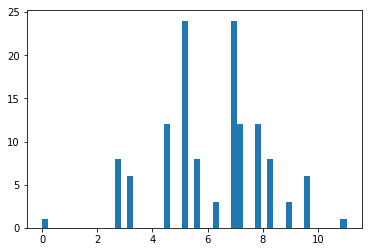

In [1061]:
from statmechlib.preprocessing import pair_dist_cutoff, force_targ
# Total pair potential
pos = targ_dict['relax']['xyz'][0]
bx = targ_dict['relax']['box'][0]
rr, rx = pair_dist_cutoff(pos, bx, 5.5)

plt.hist(rr[0], 50)
#r = np.linspace(0., rcut, 201)

In [1062]:
# embedding function
F = lambda d, a: a[0]*d**0.5 + a[1]*d + a[2]*d**2

V = lambda r, aa, cc: sum([a*(rc - r)**3 for a, rc in zip(aa, cc) if r < rc])

# Cohesive potential (cubic splines - same form as V)
phi = lambda r, aa, cc: sum([a*(rc - r)**3 for a, rc in zip(aa, cc) if r < rc])

In [1063]:
#optimal_parameters.append(tuple([output[1:], params_uopt]))
pair_y = optimal_parameters[1][1][2:]
par = optimal_parameters[1][1][:2]
many_y = [par[0], 0.0, par[1]]

In [1064]:
#many_y = [multi_pars[0][0], 0.0, multi_pars[0][1]]
#pair_y = multi_pars[0][2:]

In [1065]:
#V_x_r = [2.5, 2.75, 3.25, 3.75, 4.5, 5.5]
V_x_r = stats_opt['hyperparams']
rho_x_r = stats_opt['hyperparams'][-1:]
rho_x_a = [1.0]

In [1066]:
stats_opt['hyperparams'], many_y, pair_y

([2.75, 3.25, 3.75, 4.356, 5.0, 5.5],
 [-0.6403830910889873, 0.0, 4.554279241792763e-05],
 array([14.75954237, -3.2893096 ,  3.00811037, -1.45207629,  0.36451756,
        -0.04731042]))

In [1067]:
rho_x_a, rho_x_r, many_y, V_x_r, pair_y

([1.0],
 [5.5],
 [-0.6403830910889873, 0.0, 4.554279241792763e-05],
 [2.75, 3.25, 3.75, 4.356, 5.0, 5.5],
 array([14.75954237, -3.2893096 ,  3.00811037, -1.45207629,  0.36451756,
        -0.04731042]))

In [1068]:
ene = []
for a in np.linspace(0.5, 2.0, 101):
    z = a*rr
    u_pair = 0.5*np.sum([V(x, pair_y, V_x_r) for x in z.flatten() if x > 0.1])

    u_many = 0.0
    for i in range(z.shape[0]):
        #print(z[i])
        d = np.sum([phi(x, rho_x_a, rho_x_r) for x in z[i] if x > 0.1])
        #print('d',a, d)
        u_many += F(d, many_y)

    ene.append([a, u_pair, u_many, u_pair+u_many])
    #print(a, u_pair, u_many, u_pair + u_many)

#print(ene)
ene = np.array(ene)
#ene2 = np.array(ene2)
#ene

Text(0,0.5,'U')

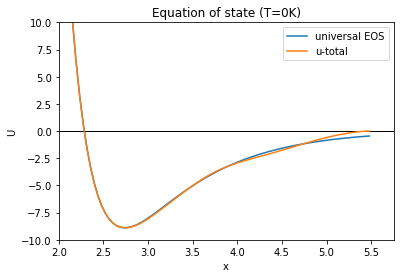

In [1069]:
#plt.plot(ene[:,0], ene[:,1]/54, label='pair')
#plt.plot(ene[:,0], ene[:,2]/54, label='manybody')
plt.title('Equation of state (T=0K)')
plt.plot(ene[:,0]*2.74, [eos(x) for x in ene[:,0]], label='universal EOS')
plt.plot(ene[:,0]*2.74, ene[:,3]/128, label='u-total')
#plt.plot(ene2[:,0], ene2[:,3]/54, label='f-total')
plt.hlines(0.0,0.5,6.0,lw=1)
plt.legend()
plt.xlim(2.0, 5.75)
plt.ylim(-10,10)
#plt.xlim(2.5, 3.0)
#plt.ylim(-9,-8.8)

plt.xlabel('x')
plt.ylabel(r'U')

In [39]:
rho_a = [1.0]
rho_r = [stats_opt['hyperparams'][-1]]

pair_a = pars_in1[2:]
pair_r = stats_opt['hyperparams']

many_a = [pars_in[0], 0.0, pars_in[1]]

In [40]:
# Ranges of densities and separations

nr = 5000
rcut = stats_opt['hyperparams'][-1]
dr = rcut/nr

rhomax = 12.0*phi(1.5, rho_a, rho_r)
print('rhomax:', rhomax)
#rhomax = 1000.0
nrho = 5000
drho = rhomax/nrho

ri = 1.0
ro = 2.0

# W properties
na = 74
ma = 183.84
lc = 3.1653
alat = 'bcc'

# System composition
n_el = 1
el_name = ['W']

rhomax: 768.0


In [41]:
def u_trans(r, unucl, ueq, ri=1.0, ro=2.0):
    """Transition between the core and equillibrium potentials"""
    if r < ri:
        return unucl
    elif r < ro:
        x = (ro + ri - 2*r)/(ro - ri)
        eta = 3/16*x**5 - 5/8*x**3 + 15/16*x + 1/2
        return ueq + eta*(unucl - ueq)
    else:
        return ueq

In [42]:
from statmechlib.forcefields import u_core

# prepare lists of values
dens = np.linspace(0., rhomax-drho, nrho, endpoint=True)
r = np.linspace(0., rcut-dr, nr, endpoint=True)
r2 = np.linspace(0., rcut, 201)

fembd = [F(d, many_a) for d in dens] # W
edens = np.array([phi(x, rho_a, rho_r) for x in r])

# 1. Cubic spline for r > r_o
f_outer = [V(x, pair_a, pair_r) for i, x in enumerate(r)]
# 2. Repulsive core for r < r_i (precalculate up to r_o)
f_inner = [0.0] + [u_core(x) for x in r[1:]]
# 3. Transition region for r_i < r < r_o
fpair = [x*u_trans(x, f_inner[i], f_outer[i]) for i, x in enumerate(r)]
#fpair = f_outer

In [708]:
# LAMMPS format
pot_path = '../sim/potentials'

with open(os.path.join(pot_path, 'W_lvnew.eam.fs'), 'w') as fo:
    
    # Comment section
    fo.write('Comment 1\n')
    fo.write('Comment 2\n')
    fo.write('Comment 3\n')
    
    # Number of elements
    fo.write(f"{n_el:5d} ")
    for i in range(n_el):
        fo.write(f"{el_name[i]:2}")
    fo.write("\n")
    
    # number of grid points, step size, and cutoff
    fo.write(f"{nrho:5d}{drho:24.16e}{nr:5d}{dr:24.16e}{rcut:24.16e}\n")
    
    # atomic number, mass, lattice size, lattice type
    fo.write(f"{na:5d} {ma:14.4f} {lc:14.4f} {alat:10}\n")
    
    # Embeding function
    for i in range(nrho//4):
        fo.write("{0:20.12e}{1:20.12e}{2:20.12e}{3:20.12e}\n".format(*fembd[i*4:i*4+4]))
    
    # Electronic density
    for i in range(nr//4):
        fo.write("{0:20.12e}{1:20.12e}{2:20.12e}{3:20.12e}\n".format(*edens[i*4:i*4+4]))
        
    # Pair potential
    for i in range(nr//4):
        fo.write("{0:20.12e}{1:20.12e}{2:20.12e}{3:20.12e}\n".format(*fpair[i*4:i*4+4]))